In [1]:
#数据分析及处理
#数据概况
#20200440714 任予行
import csv
import numpy as np

train_dataset = 'data3/train_dataset.csv'
test_dataset = 'data3/test_dataset.csv'

with open(train_dataset, encoding = 'utf-8') as trainset:
    traindatas = np.loadtxt(trainset, str, delimiter = "\t", skiprows = 1)

with open(test_dataset, encoding = 'utf-8') as testset:
    testdatas = np.loadtxt(testset, str, delimiter = "\t", skiprows = 1)

print("在训练集中，共有{}条数据，其中每条数据有{}个特征".format(traindatas.shape[0], traindatas.shape[1]))
print("在测试集中，共有{}条数据，其中每条数据有{}个特征".format(testdatas.shape[0], testdatas.shape[1]))

在训练集中，共有15016条数据，其中每条数据有19个特征
在测试集中，共有10000条数据，其中每条数据有18个特征


In [2]:
#查看某一条数据
#20200440714 任予行
index = 0
print("第{}条训练数据是\n{}".format(index+1, traindatas[index]))
print("第{}条测试数据是\n{}".format(index+1, testdatas[index]))

第1条训练数据是
['access:test_d:20180101111639:bBp1' '2018/1/1 11:16' 'test_d' 'login'
 'otp' '192.168.100.101' '内网' '1级'
 '{"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl":"销售部"}' 'web' 'desktop'
 'think_pad_e460' 'windows' 'windows 10' 'chrome' 'chrome 90' 'coremail'
 'management' '0']
第1条测试数据是
['access:test_c:20191023212545:H2in' '2019/10/23 21:25' 'test_c' 'sso' ''
 '27.10.135.254' '代理IP' '3级'
 '{"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":"江北区"}' 'web' 'desktop'
 'macbook' 'macOS' 'macOS Big Sur 11' 'safari' 'safari 13' 'order-mgnt'
 'sales']


In [3]:
#数据预处理
#20200440714
traindata = traindatas[:, [3, 4, 6, 7, 9, 10, 17]]
trainlabel = traindatas[:, [18]]
testdata = testdatas[:, [3, 4, 6, 7, 9, 10, 17]]
# print(traindata, trainlabel)

In [4]:
# 将以上字段映射成数字
#20200440714 任予行
encoder_map = { 'login': 1, 'sso': 2, 
                'pwd': 1, 'sms': 2, 'otp': 3, 'qr': 4,
                '家庭宽带': 1, '代理IP': 2, '内网': 3, '公共宽带': 4,
                '1级': 1, '2级': 2, '3级': 3,
                'app': 1, 'web': 2, 
                'desktop': 1, 'mobile': 2,
                'sales': 1, 'finance': 2, 'management': 3, 'hr': 4,
                '': 0 }

In [5]:
# 将字段编码成数字
for iter in range(len(traindata)):
    for item in range(len(traindata[iter])):
        # print(traindata[iter])
        traindata[iter][item] = encoder_map[traindata[iter][item]]
        # print(traindata[iter])

for iter in range(len(testdata)):
    for item in range(len(testdata[iter])):
        testdata[iter][item] = encoder_map[testdata[iter][item]]

In [7]:
# 转换为nparray
data_X = np.array(traindata, dtype='float32')
data_Y = np.array(trainlabel, dtype='float32')
# 检查大小
print('data shape', data_X.shape, data_Y.shape)
print('data_x shape[1]', data_X.shape[1])

data shape (15016, 7) (15016, 1)
data_x shape[1] 7


In [8]:
#模型组网

import paddle
import paddle.nn as nn

# 定义动态图
class Classification(paddle.nn.Layer):
    def __init__(self):
        super(Classification, self).__init__()
        self.drop = paddle.nn.Dropout(p=0.5)
        # 定义一层全连接层，输出维度是2，激活函数为None，即不使用激活函数
        self.fc1 = paddle.nn.Linear(7, 8)
        self.fc2 = paddle.nn.Linear(8, 2)
    
    # 网络的前向计算函数
    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.drop(x)
        pred = self.fc2(x)
        return pred

In [9]:
#配置参数及训练

# 定义绘制训练过程的损失值变化趋势的方法draw_train_process
train_nums = []
train_costs = []
def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
#定义损失函数
#损失函数使用【R-Drop：摘下SOTA的Dropout正则化策略】里的kl_loss：
#20200440714 任予行
import paddle
import paddle.nn.functional as F

class kl_loss(paddle.nn.Layer):
    def __init__(self):
       super(kl_loss, self).__init__()

    def forward(self, p, q, label):
        ce_loss = 0.5 * (F.mse_loss(p, label=label)) + F.mse_loss(q, label=label)
        kl_loss = self.compute_kl_loss(p, q)

        # carefully choose hyper-parameters
        loss = ce_loss + 0.3 * kl_loss 

        return loss

    def compute_kl_loss(self, p, q):
        
        p_loss = F.kl_div(F.log_softmax(p, axis=-1), F.softmax(q, axis=-1), reduction='none')
        q_loss = F.kl_div(F.log_softmax(q, axis=-1), F.softmax(p, axis=-1), reduction='none')

        # You can choose whether to use function "sum" and "mean" depending on your task
        p_loss = p_loss.sum()
        q_loss = q_loss.sum()

        loss = (p_loss + q_loss) / 2

        return loss

In [11]:
#模型训练

import paddle.nn.functional as F
y_preds = []
labels_list = []
BATCH_SIZE = 8
train_data = data_X
test_data = data_Y
compute_kl_loss = kl_loss()

def train(model):
    print('start training ... ')
    # 开启模型训练模式
    model.train()
    EPOCH_NUM = 5
    train_num = 0
    scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.0025, T_max=int(traindatas.shape[0]/BATCH_SIZE*EPOCH_NUM), verbose=False)
    optimizer = paddle.optimizer.Adam(learning_rate=scheduler, parameters=model.parameters())
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(train_data)
        # 将训练数据进行拆分，每个batch包含50条数据
        mini_batches = [train_data[k: k+BATCH_SIZE] for k in range(0, len(train_data), BATCH_SIZE)]
        for batch_id, data in enumerate(mini_batches):
            features_np = np.array(data[:, :8], np.float32)
            labels_np = np.array(data[:, -1:], np.float32)

            features = paddle.to_tensor(features_np)
            labels = paddle.to_tensor(labels_np)

            #前向计算
            y_pred1 = model(features)
            y_pred2 = model(features)
            cost = compute_kl_loss(y_pred1, y_pred2, label=labels)
            # cost = F.mse_loss(y_pred, label=labels)
            train_cost = cost.numpy()[0]
            #反向传播
            cost.backward()
            #最小化loss，更新参数
            optimizer.step()
            # 清除梯度
            optimizer.clear_grad()
            if batch_id % 500 == 0 and epoch_id % 1 == 0:
                print("Pass:%d,Cost:%0.5f"%(epoch_id, train_cost))

            train_num = train_num + BATCH_SIZE
            train_nums.append(train_num)
            train_costs.append(train_cost)

model = Classification()
train(model)

start training ... 
Pass:0,Cost:28.31236
Pass:0,Cost:0.80606
Pass:0,Cost:0.55263
Pass:0,Cost:0.38404
Pass:1,Cost:0.21630
Pass:1,Cost:0.59808
Pass:1,Cost:0.13844
Pass:1,Cost:0.11986
Pass:2,Cost:0.15962
Pass:2,Cost:0.22131
Pass:2,Cost:0.19213
Pass:2,Cost:0.05563
Pass:3,Cost:0.20655
Pass:3,Cost:0.12658
Pass:3,Cost:0.26806
Pass:3,Cost:0.13074
Pass:4,Cost:0.31021
Pass:4,Cost:0.19274
Pass:4,Cost:0.25239
Pass:4,Cost:0.27181


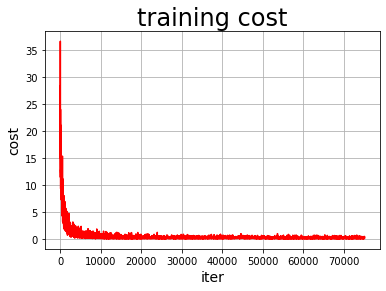

In [12]:
#绘制趋势曲线
#20200440714 任予行
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

draw_train_process(train_nums, train_costs)

In [13]:
#保存预测结果
#模型预测
#20200440714 任予行
predict_result = []
for infer_feature in testdata:
    # print(infer_feature)
    infer_feature = paddle.to_tensor(np.array(infer_feature, dtype='float32'))
    result = model(infer_feature)
    # print(result)
    predict_result.append(result)

In [14]:
#将结果写入.CSV文件中
#20200440714 任予行
import os
import pandas as pd

id_list = [item for item in range(1, 10001)]
label_list = []
csv_file = 'data3/submission.csv'

for item in range(len(id_list)):
    label = np.argmax(predict_result[item])
    label_list.append(label)

data = {'id':id_list, 'ret':label_list}
df = pd.DataFrame(data)
df.to_csv(csv_file, index=False, encoding='utf8')